In [7]:
import torch
from transformers import Trainer, TrainingArguments
from transformers import AlbertModel, AlbertConfig, AlbertTokenizer, AlbertForPreTraining, ConvbertForPreTraining, ConvbertModel
from dataset import SOPDataset, MyTrainer, collate_batch
import os

model_dir = 'E:/ConvbertData/convbert_12/output'
#model_dir = 'E:/ConvbertData/albert/model_dir'

def get_last_checkpoint(dir_name):
    max_check = -1
    result = None
    for filename in os.listdir(dir_name):
        if 'checkpoint' in filename:
            step = int(filename.split('-')[1])
            if step > max_check:
                max_check = step
                result = filename
    return os.path.join(dir_name, result)

tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = ConvbertModel.from_pretrained(get_last_checkpoint(model_dir))
#model = AlbertModel.from_pretrained(model_dir)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
train_dataset = SOPDataset(directory='E:/ConvbertData/text_data/cache', batch_size=10, tokenizer=tokenizer, mlm_probability=0.15)

In [8]:
import numpy as np
import torch.nn as nn
import tqdm

In [9]:
class IndexClassifier(nn.Module):
    def __init__(self, transformer, layer):
        super(IndexClassifier, self).__init__()
        self.transformer = transformer
        self.transformer.train(False)
        self.layer = layer
        self.dense = nn.Linear(768, 512)
        
    def forward(self, inputs):
        output = self.transformer(inputs['input_ids'], attention_mask=inputs['attention_mask'], output_hidden_states=True)
        embeddings = output[2][self.layer]
        return self.dense(embeddings)

In [10]:
def train_model(layer, iterations = 10000):
    index_model = IndexClassifier(model, layer).to(device)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    optimizer = torch.optim.Adagrad(index_model.parameters())

    iterator = iter(train_dataset)

    for i in tqdm.tqdm(range(iterations)):
        batch = next(iterator)
        inputs = batch.to(device)
        batch_size = inputs['input_ids'].shape[0]
        seq_len = inputs['input_ids'].shape[1]
        optimizer.zero_grad()
        outputs = index_model(inputs)
        target = torch.cuda.LongTensor([np.arange(0, seq_len)] * batch_size) * inputs['attention_mask']
        loss = loss_fn(outputs.view(batch_size * seq_len, 512), target.view(-1))
        loss.backward()
        optimizer.step()
        #if it % 10000 == 0:
        #    print(loss.item())
    
    it = 0
    loss = 0
    tp = 0
    total = 0
    index_model.train(False)
    for i in tqdm.tqdm(range(1000)):
        batch = next(iterator)
        inputs = batch.to(device)
        batch_size = inputs['input_ids'].shape[0]
        seq_len = inputs['input_ids'].shape[1]
        outputs = index_model(inputs)
        target = torch.cuda.LongTensor([np.arange(0, seq_len)] * batch_size) * inputs['attention_mask']
        result = torch.argmax(nn.functional.softmax(outputs, -1), -1)
        total += inputs['attention_mask'].sum().item()
        tp += (result == target).sum().item()
        current_loss = loss_fn(outputs.view(batch_size * seq_len, 512), target.view(-1))
        loss += current_loss.item()
    return loss/total, tp/total
        
train_model(1, iterations = 100)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:32<00:00,  6.54it/s]


(0.0011694460244013286, 0.19702534224184715)

In [11]:
result = []
for i in range(0, 13):
    result.append(train_model(i))
    print(result[-1])
    
print(result)

  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(4.3916603228187704e-09, 0.9969412758611302)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(2.601552270329988e-07, 0.9968324568528885)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(1.5246452806417724e-07, 0.996860688239641)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(1.828031126734396e-06, 0.9957678740438995)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(2.5828355647035167e-06, 0.9953104274423012)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(1.4414157382308343e-06, 0.9959886623166265)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(8.218801327302222e-07, 0.9964355620223222)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(1.6125885257785175e-06, 0.9960417041797763)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(1.0462084049168679e-06, 0.9963101334797824)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(1.8744767209593013e-06, 0.9958569375416265)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(2.4405745790799178e-06, 0.9954119014549588)


  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]

(1.7051136918649007e-06, 0.9958328677948455)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.77it/s]


(1.7492546829082654e-05, 0.9834972774145389)
[(4.3916603228187704e-09, 0.9969412758611302), (2.601552270329988e-07, 0.9968324568528885), (1.5246452806417724e-07, 0.996860688239641), (1.828031126734396e-06, 0.9957678740438995), (2.5828355647035167e-06, 0.9953104274423012), (1.4414157382308343e-06, 0.9959886623166265), (8.218801327302222e-07, 0.9964355620223222), (1.6125885257785175e-06, 0.9960417041797763), (1.0462084049168679e-06, 0.9963101334797824), (1.8744767209593013e-06, 0.9958569375416265), (2.4405745790799178e-06, 0.9954119014549588), (1.7051136918649007e-06, 0.9958328677948455), (1.7492546829082654e-05, 0.9834972774145389)]


In [12]:
(9.47352011726333e-10, 0.9968193313478251)

albert [(3.2626636499744777e-09, 0.9974775540143971), (5.227441220872217e-07, 0.9972558971361003), (1.8203832469968202e-05, 0.9771521703534178), (0.0003443862991534884, 0.600711628272535), (0.0013903884815532701, 0.01083300354891411), (0.0015854043168583192, 0.002540712943774336), (0.0015612912199005947, 0.0025360403062965504), (0.0014952894962990849, 0.005022793455447313), (0.0015807216924212145, 0.00238922438443017), (0.0015591000802348276, 0.0023569901208507285), (0.0015763058481761392, 0.002469093873975847), (0.0015853887640640107, 0.002549201787245934), (0.001576727379028436, 0.002534396191512155)]

convbert [(4.3916603228187704e-09, 0.9969412758611302), (2.601552270329988e-07, 0.9968324568528885), (1.5246452806417724e-07, 0.996860688239641), (1.828031126734396e-06, 0.9957678740438995), (2.5828355647035167e-06, 0.9953104274423012), (1.4414157382308343e-06, 0.9959886623166265), (8.218801327302222e-07, 0.9964355620223222), (1.6125885257785175e-06, 0.9960417041797763), (1.0462084049168679e-06, 0.9963101334797824), (1.8744767209593013e-06, 0.9958569375416265), (2.4405745790799178e-06, 0.9954119014549588), (1.7051136918649007e-06, 0.9958328677948455), (1.7492546829082654e-05, 0.9834972774145389)]

NameError: name 'albert' is not defined

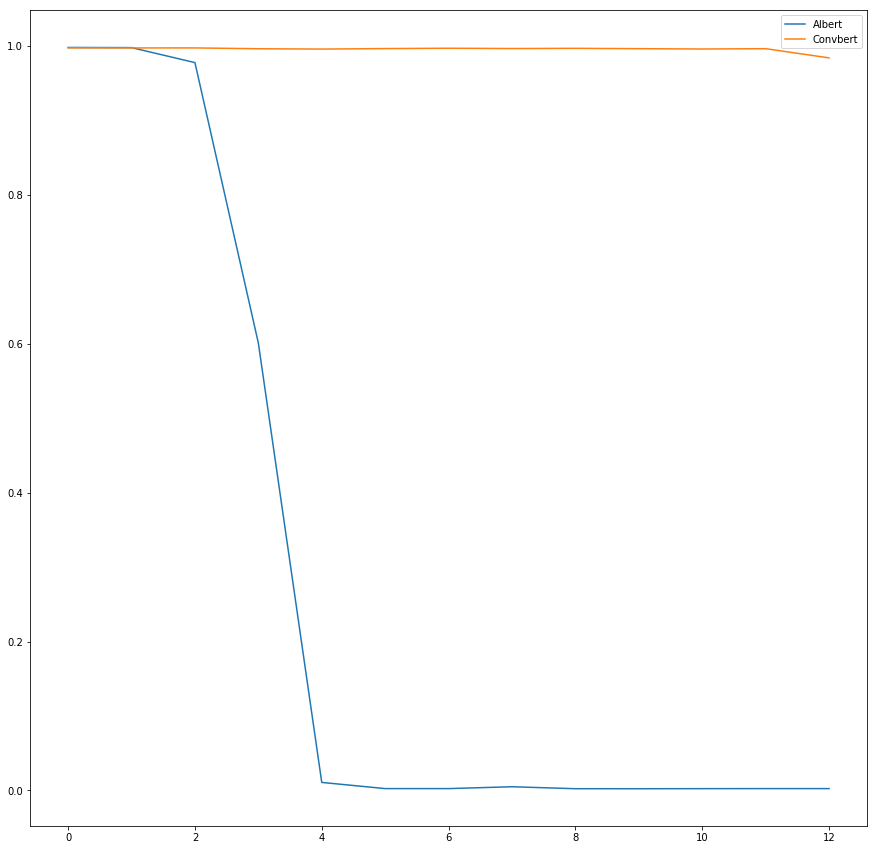

In [5]:
import matplotlib.pyplot as plt
import numpy as np

albert = [(3.2626636499744777e-09, 0.9974775540143971), (5.227441220872217e-07, 0.9972558971361003), (1.8203832469968202e-05, 0.9771521703534178), (0.0003443862991534884, 0.600711628272535), (0.0013903884815532701, 0.01083300354891411), (0.0015854043168583192, 0.002540712943774336), (0.0015612912199005947, 0.0025360403062965504), (0.0014952894962990849, 0.005022793455447313), (0.0015807216924212145, 0.00238922438443017), (0.0015591000802348276, 0.0023569901208507285), (0.0015763058481761392, 0.002469093873975847), (0.0015853887640640107, 0.002549201787245934), (0.001576727379028436, 0.002534396191512155)]
convbert = [(4.3916603228187704e-09, 0.9969412758611302), (2.601552270329988e-07, 0.9968324568528885), (1.5246452806417724e-07, 0.996860688239641), (1.828031126734396e-06, 0.9957678740438995), (2.5828355647035167e-06, 0.9953104274423012), (1.4414157382308343e-06, 0.9959886623166265), (8.218801327302222e-07, 0.9964355620223222), (1.6125885257785175e-06, 0.9960417041797763), (1.0462084049168679e-06, 0.9963101334797824), (1.8744767209593013e-06, 0.9958569375416265), (2.4405745790799178e-06, 0.9954119014549588), (1.7051136918649007e-06, 0.9958328677948455), (1.7492546829082654e-05, 0.9834972774145389)]

plt.figure(figsize=(15, 15))
plt.plot(np.arange(0, 13), [pair[1] for pair in albert], label='Albert')
plt.plot(np.arange(0, 13), [pair[1] for pair in convbert], label='Convbert')
plt.legend()

plt.show()